In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm

In [193]:
df = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0015.long_combined.csv")

In [194]:
y = np.array(df['omega_NE'], dtype=np.double)
dy = np.array(df['uncertainty_omega_NE'], dtype=np.double)

In [195]:
# Robust Estimation of means:
# Huber weight function

def Huber(ei, sigma, s, a = 1.345):
    w1 = 1/sigma ** 2
    w2 = 1/sigma ** 2 * (a / (np.abs(ei) / (sigma * s)))
    weights = np.where(np.abs(ei) <= a * sigma * s, w1, w2)
    return weights

# For robust estimation of mean:

def ZL_robust_mean(y_, dy_, max_iter=50, tol=1e-6):
    """Output:
    robust mean,
    s (a sqrt(reduced chi2-like scale factor), s^2 ~ reduced chi2)"""
    y = y_
    dy = dy_
    y_bar = np.average(y, weights=1/dy**2)
    s = 1.0
    for _ in range(max_iter):
        ei = y - y_bar
        w = Huber(ei, dy, s)
        y_bar_old = y_bar
        y_bar = np.sum(w * y) / np.sum(w)
        mad = np.median(np.abs(y - y_bar) / dy)
        s = 1.4826 * mad if mad > 0 else 1.0
        # tolerance check   
        if np.abs(y_bar - y_bar_old) < tol * (np.abs(y_bar_old) + 1e-12):
            break
    return y_bar, s

def bootstrap_ZL_robust_mean(y, dy, n_boot=10000, random_state=None):
    """Output:
    mean of bootstrap samples,
    std of bootstrap samples,
    all bootstrap samples
    """
    rng = np.random.default_rng(random_state)
    boot_means = np.empty(n_boot)
    n = len(y)
    for i in tqdm.tqdm(range(n_boot)):
        indices = rng.integers(0, n, n)
        y_sample = y[indices]
        dy_sample = dy[indices]
        boot_means[i] = ZL_robust_mean(y_sample, dy_sample)[0]
    return boot_means.mean(), boot_means.std(), boot_means

# Code for robust linear regression using IRLS and Huber weights

def irls_robust_linear(x, y, dy, max_iter=50, tol=1e-6):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    dy = np.asarray(dy, dtype=float)

    # Design matrix: y = a + b x
    A = np.vstack([np.ones_like(x), x]).T

    # Initial conditions
    n = len(y)
    s = 1.0
    w = np.ones(n) / dy**2

    def solve_wls(A, y, weights):
        W = np.sqrt(weights)
        Aw = A * W[:, None]
        yw = y * W
        theta, *_ = np.linalg.lstsq(Aw, yw, rcond=None)
        return theta

    # Initial least squares solution
    theta = solve_wls(A, y, w)

    for _ in range(max_iter):
        theta_old = theta.copy()
        s_old = s

        # 1. compute residuals
        y_fit = A @ theta
        r = y - y_fit

        # 2. update scale s using MAD of |r| / dy
        mad = np.median(np.abs(r) / dy)
        s = 1.4826 * mad if mad > 0 else 1.0

        # 3. update weights using YOUR huber function
        w = Huber(r, dy, s)

        # 4. solve weighted least squares
        theta = solve_wls(A, y, w)

        # 5. convergence test
        if np.linalg.norm(theta - theta_old) < tol * (np.linalg.norm(theta_old) + 1e-12) and \
           abs(s - s_old) < tol * (s_old + 1e-12):
            break
    beta0, beta1 = theta
    return beta0, beta1, s, w

def bootstrap_irls(x, y, dy, n_boot=10000, random_state=None):
    """
    Bootstrap IRLS over (x, y, dy) triplets.
    
    Returns:
        beta0_samples : array of intercepts
        beta1_samples : array of slopes
        s_samples : array of scale estimates
    """
    import numpy as np

    if random_state is not None:
        np.random.seed(random_state)

    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.asarray(dy)

    n = len(x)

    beta0_samples = np.empty(n_boot)
    beta1_samples = np.empty(n_boot)
    s_samples = np.empty(n_boot)

    for i in tqdm.tqdm(range(n_boot)):
        # 1. Resample indices with replacement
        idx = np.random.randint(0, n, size=n)

        # 2. Resample triplets together
        xb = x[idx]
        yb = y[idx]
        dyb = dy[idx]

        # 3. Run IRLS on bootstrap sample
        beta0, beta1, s, _ = irls_robust_linear(xb, yb, dyb)

        # 4. Store results
        beta0_samples[i] = beta0
        beta1_samples[i] = beta1
        s_samples[i] = s

    return beta0_samples, beta1_samples, s_samples


In [196]:
_,_,res = bootstrap_ZL_robust_mean(y,dy)

100%|██████████| 10000/10000 [00:03<00:00, 2658.87it/s]


# Robust Regression

In [197]:
beta0_, beta1_, s_ = bootstrap_irls(x = df['omega_N'], y = df['omega_NE'], dy = df['uncertainty_omega_NE'], n_boot=10000, random_state=None)

100%|██████████| 10000/10000 [00:07<00:00, 1329.41it/s]


In [198]:
np.mean(beta1_)

0.0027126932140886626

In [199]:
np.std(beta1_)

0.041586226805239074

(array([   3.,    0.,   10.,   14.,   32.,   59.,   90.,  160.,  243.,
         369.,  462.,  624.,  844.,  937.,  992., 1009.,  974.,  857.,
         667.,  532.,  396.,  266.,  191.,  131.,   63.,   31.,   22.,
           9.,    9.,    4.]),
 array([-7.01803482e-04, -6.78281223e-04, -6.54758963e-04, -6.31236704e-04,
        -6.07714445e-04, -5.84192185e-04, -5.60669926e-04, -5.37147666e-04,
        -5.13625407e-04, -4.90103148e-04, -4.66580888e-04, -4.43058629e-04,
        -4.19536369e-04, -3.96014110e-04, -3.72491851e-04, -3.48969591e-04,
        -3.25447332e-04, -3.01925072e-04, -2.78402813e-04, -2.54880554e-04,
        -2.31358294e-04, -2.07836035e-04, -1.84313775e-04, -1.60791516e-04,
        -1.37269257e-04, -1.13746997e-04, -9.02247377e-05, -6.67024783e-05,
        -4.31802189e-05, -1.96579595e-05,  3.86429987e-06]),
 <BarContainer object of 30 artists>)

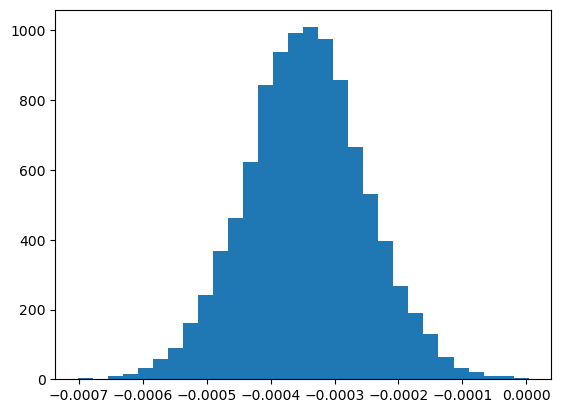

In [200]:
plt.hist(beta0_, bins=30)